Sam Brown
Homework problem 1.2, n-dimensional
NEED TO FIX GRADIENT

In [ ]:
pip install benchmarkfcns==2.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.0/148.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import torch
import matplotlib.pyplot as plt
from benchmarkfcns import sumsquares
torch.set_default_dtype(torch.float64)

Sum Squares Function:
$$f(\mathbf{x})=f(x_1, ..., x_n)=\sum_{i=1}^{n}{ix_i^2}$$
Gradient calculation:
$$\frac{df}{dx_i} = \frac{d}{dx_i}(i ̇ x_i^2) = i \cdot 2x_i$$
$$\nabla f(\mathbf{x}) = 2 \cdot w \odot x$$

Hessian Calculation:
$$H = 2 \cdot \text{diag}(1, 2, 3, \dots, n)$$

$$H = \begin{bmatrix}
2 \cdot 1 & 0 & 0 & \cdots & 0 \\
0 & 2 \cdot 2 & 0 & \cdots & 0 \\
0 & 0 & 2 \cdot 3 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 2 \cdot n
\end{bmatrix}$$

In [ ]:
n = 2  # Number of features

#function
def f(x):
  # print(x.shape)

  dim = x.shape[0]
  indices = torch.arange(1, dim+1, dtype=x.dtype).unsqueeze(1)  # shape: (n, 1)
  output = torch.sum(indices * (x ** 2))
  return output

#gradient
def grad_f(x):
  assert x.shape == (dim,1)  # ensure correct feature size

  gradient = 2.0 * torch.diag(torch.arange(1,x.shape[0]+1)) @ x

  return gradient

# hessian
def hes(x):
  indices = torch.arange(1, x.shape[0] + 1)
  H = 2.0 * torch.diag(indices)  # Construct diagonal Hessian matrix
  return H

# gradient using AD
def grad_f_AD(x):
  dim = x.shape[0]
  assert x.shape == (dim, 1) # ensuring input is valid in context
  #track the input
  x.requires_grad = True
  y = f(x)
  dy = torch.autograd.grad(outputs=y, inputs=x,grad_outputs=torch.ones_like(y), create_graph=True)[0]

  #detach variables to release memeory
  x = x.detach()
  y = y.detach()
  dy = dy.detach()

  return dy

#hessian using AD
def hes_f_AD(x):
  x.requires_grad = True
  y = f(x)
  dy = torch.autograd.grad(outputs = y, inputs = x, grad_outputs = torch.ones_like(y), create_graph = True)[0]

  #initialize hessian
  dim = x.shape[0]
  H = torch.zeros((dim, dim), dtype=x.dtype, device=x.device)

  #identity matrix
  I = torch.eye(dim, dtype=x.dtype, device = x.device)

  # for loop through identity matrix to compute second derivates
  for i in range(dim):
    grad_output = I[i].unsqueeze(-1)
    second_grad = torch.autograd.grad(outputs=dy, inputs = x, grad_outputs=grad_output, create_graph=True)[0]
    H[i] = second_grad.squeeze()

  #detach variables
  H = H.detach()
  dy = dy.detach()
  x = x.detach()

  return H

In [ ]:
#test function
X = torch.rand(1000, n, 1)

f1Out = torch.zeros(1000)
for i in range(1000):
    f1Out[i] = torch.as_tensor(sumsquares(X[i].T))

passed = True
for i in range(1000):
    f2 = f(X[i])
    if abs(f1Out[i] - f2) > 0.0005:
        passed = False
        print('error')
        print(f1Out[i])
        print(f2)
        break

if passed:
    print('passed')




passed


In [ ]:
dim = n
x = torch.randn(dim, 1)
v = torch.randn_like(x)
v = v / torch.norm(v)

max_iters = 32
h = torch.zeros(max_iters)
err0 = torch.zeros(max_iters) # error from zero order T.P.
err1 = torch.zeros(max_iters) # error from first order T.P.
err2 = torch.zeros(max_iters) # error from second order T.P.
for i in range(max_iters):
  h[i] = 2**(-i) # iterate h down

  #regular
  # fv = f(x + h[i]*v)
  # T0 = f(x)
  # T1 = T0 + h[i] * grad_f(x).T @ v
  # T2 = T1 + .5*(h[i]**2) * v.T @ hes(x) @ v

  # #using AD
  fv = f(x+h[i]*v).detach()
  T0 = f(x).detach()
  T1 = T0 + h[i] * (grad_f_AD(x)).T @ v
  T2 = T1 + .5*(h[i]**2) * v.T @ hes_f_AD(x) @ v


  err0[i] = torch.norm(fv - T0)
  err1[i] = torch.norm(fv - T1)
  err2[i] = torch.norm(fv - T2)
  print('h: %.3e, \t err0: %.3e, \t err1: %.3e, \t err2: %.3e' % (h[i], err0[i], err1[i], err2[i]))



h: 1.000e+00, 	 err0: 1.387e-01, 	 err1: 4.651e+00, 	 err2: 0.000e+00
h: 5.000e-01, 	 err0: 1.093e+00, 	 err1: 1.163e+00, 	 err2: 1.776e-15
h: 2.500e-01, 	 err0: 8.374e-01, 	 err1: 2.907e-01, 	 err2: 0.000e+00
h: 1.250e-01, 	 err0: 4.914e-01, 	 err1: 7.267e-02, 	 err2: 1.776e-15
h: 6.250e-02, 	 err0: 2.638e-01, 	 err1: 1.817e-02, 	 err2: 0.000e+00
h: 3.125e-02, 	 err0: 1.365e-01, 	 err1: 4.542e-03, 	 err2: 1.776e-15
h: 1.562e-02, 	 err0: 6.937e-02, 	 err1: 1.135e-03, 	 err2: 0.000e+00
h: 7.812e-03, 	 err0: 3.497e-02, 	 err1: 2.839e-04, 	 err2: 1.776e-15
h: 3.906e-03, 	 err0: 1.755e-02, 	 err1: 7.097e-05, 	 err2: 1.776e-15
h: 1.953e-03, 	 err0: 8.795e-03, 	 err1: 1.774e-05, 	 err2: 1.776e-15
h: 9.766e-04, 	 err0: 4.402e-03, 	 err1: 4.435e-06, 	 err2: 0.000e+00
h: 4.883e-04, 	 err0: 2.202e-03, 	 err1: 1.109e-06, 	 err2: 1.776e-15
h: 2.441e-04, 	 err0: 1.101e-03, 	 err1: 2.772e-07, 	 err2: 0.000e+00
h: 1.221e-04, 	 err0: 5.507e-04, 	 err1: 6.930e-08, 	 err2: 0.000e+00
h: 6.104e-05, 	 err0

(array([1.e-18, 1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04,
        1.e-02, 1.e+00, 1.e+02, 1.e+04]),
 [Text(0, 1e-18, '$\\mathdefault{10^{-18}}$'),
  Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-12, '$\\mathdefault{10^{-12}}$'),
  Text(0, 1e-10, '$\\mathdefault{10^{-10}}$'),
  Text(0, 1e-08, '$\\mathdefault{10^{-8}}$'),
  Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$')])

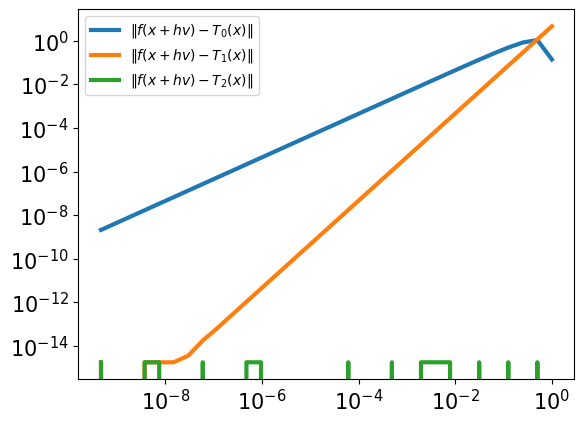

In [ ]:
plt.loglog(h, err0, linewidth = 3)
plt.loglog(h, err1, linewidth = 3)
plt.loglog(h, err2, linewidth = 3)
plt.legend(['$\|f(x+hv) - T_0(x)\|$', '$\|f(x+hv) - T_1(x)\|$', '$\|f(x+hv) - T_2(x)\|$'])
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)